# MACD (Moving Average Convergence Divergence) + Bollinger Bands

## Strategy Logic: MACD + Bollinger
- **BUY Signal:**
    - MACD line crosses above signal line
    - Price near or touching lower Bollinger band
- **SELL Signal:**
     - MACD line crosses below signal line
     - Price near or touching upper Bollinger band

### DataLoder Function

In [8]:
'''
DataLoder:
    Input: path of csv, where the data is stored(Extracted from Yfinance)
    Returns: Pandas DataFrame Object
    Task Performed:
        - Load CSV
        - rename 'Price' to 'Date'
        - Row 0 and 1 Other data then stock - So remove it.
        - Date is not in Date formate. so convert it into Date
        - All other to float
'''
def DataLoder(path):
    import pandas as pd
    import numpy as np
    import os
    try:
        isExist = os.path.exists(path)
        if isExist == False:
            return 0
        stock_data = pd.read_csv(path)
        if stock_data['Price'][0]== 'Ticker':
            stock_data=stock_data[1:]
        if stock_data['Price'][1]=='Date':
            stock_data=stock_data[1:]
        stock_data=stock_data.rename(columns={'Price':'Date'})
        stock_data['Date']=pd.to_datetime(stock_data['Date'])
        ignore = ['Date']
        stock_data = (stock_data.set_index(ignore, append=True)
                        .astype(float)
                        .reset_index(ignore)
                        )
        stock_data.set_index('Date', inplace=True)              # make it the index
        return stock_data
    
    except:
        print("Error Occoured while loading Data...")
        return 0



### SMA Calculator Function

In [132]:
'''
SMA_Calculator:
    Input: Pandas Dataframe Object containing Stock Data , SMA Day in numbers
    Output: Pandas Dataframe Object containing SMA column
'''
def SMA_Calculator(stock_data ,days):
    stock_data[f'SMA_{days}'] = stock_data['Close'].rolling(days).mean()
    return stock_data

### RSI Calculator Function

In [138]:
'''
RSI_Calculator:
    Input: Pandas Dataframe Object containing Stock Data
    Output: Pandas Dataframe Object containing RSI column
    Relative Strength Index (RSI) is a momentum indicator that measures the speed and magnitude of recent price changes. It ranges from 0 to 100.
    Mathematical Formula for RSI:
        - 𝑅𝑆𝐼 = 100 −(100 /1+𝑅𝑆) where 𝑅𝑆= Average Gain/Average Loss
        - RSI is typically calculated over 14 periods (14 days if using daily data).
        
'''
def RSI_Calculator(stock_data):
    delta = stock_data['Close'].diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    avg_gain = gain.rolling(14).mean()
    avg_loss = loss.rolling(14).mean()
    rs = avg_gain / avg_loss
    stock_data['RSI'] = 100 - (100 / (1 + rs))
    return stock_data

### MACD Calculator Function

In [134]:
'''
MACD_Calculator:
    Input: Pandas Dataframe Object containing Stock Data
    Output: Pandas Dataframe Object containing 'MACD' & 'Signal_Line' & 'MACD_Hist' Column
    
    MACD Line = 12_Days_EMA - 26_Days_EMA (EMA - Exponential Moving Average | Expontial Weighted Moving)
    Signal_Line = 9_Days_EMA of MACD_Line 
    Histogram = MACD_Line - Signal_Line (Shows Strength of Momentum)
'''

def MACD_Calculator(stock_data):
    import pandas as pd 
    try:
        EMA_12 = stock_data['Close'].ewm(span=12 , adjust = False).mean() # EWMA with a span of 12
        EMA_26 = stock_data['Close'].ewm(span=26 , adjust = False).mean() # EWMA with a span of 26
        stock_data['MACD'] = EMA_12 - EMA_26
        stock_data['Signal_Line'] = stock_data['MACD'].ewm(span=9, adjust=False).mean()
        stock_data['MACD_Hist'] = stock_data['MACD'] - stock_data['Signal_Line']
        return stock_data
    except:
        print("Error Occoured while calculating MACD...")
        return 0

### Bollinger Bands Calculator Function

In [15]:
'''
Bollinger_Band_Calculator:
    Input Args 1 (PD Dataframe): Data: contains Stock Data
    Input Args 2 (int): Period (for middle line)
    Input Args 3 (int): Standard Deviations
    
    Return (PD Dataframe): Object containing 'BB_Lower' & 'BB_Middle' & 'BB_Upper' Column
    
    BB_Middle = 20 Days SMA (usually)
    BB_Lower = BB_Middle - 2 *S.D. of Middle
    BB_Lower = BB_Middle + 2 *S.D. of Middle
'''
def Bollinger_Band_Calculator(stock_data ,Period = 20, SD = 2):
    import pandas as pd
    try:
        stock_data['BB_Middle'] = stock_data['Close'].rolling(Period).mean()
        stock_data['BB_Lower'] = stock_data['BB_Middle'] - ( SD * stock_data['Close'].rolling(Period).std())
        stock_data['BB_Upper'] = stock_data['BB_Middle'] + ( SD * stock_data['Close'].rolling(Period).std())
        return stock_data
    except:
        print("Error Occoured while calculating Bollinger_Band...")
        return 0

### Signal Generator Function - MACD + Bollinger 

In [123]:
'''
Signal_Generator_MACD_BB:
    Input Args (PD Dataframe): Data: contains Stock Data
    Return (PD Dataframe): Object containing 'Buy_signal_MACD_BB' & 'Sell_Signal_MACD_BB'
'''
'''def Signal_Generator_MACD_BB(stock_data):
    import pandas as pd
    try:
        stock_data['Buy_signal_MACD_BB'] = ((stock_data['MACD'] > stock_data['Signal_Line']) & stock_data['Close'] <= stock_data['BB_Lower']*1.01)
        stock_data['Sell_signal_MACD_BB'] = ((stock_data['MACD']< stock_data['Signal_Line']) & stock_data['Close'] >= stock_data['BB_Upper'])
        return stock_data
    except:
        print("Error Occoured while generating signals...")
        return 0
'''
def Signal_Generator_MACD_BB(stock_data, cooldown_days=5):
    import pandas as pd
    try:
        # Buy Signal (MACD bullish crossover near lower BB)
        stock_data['Buy_signal_MACD_BB'] = (
            (stock_data['MACD'] > stock_data['Signal_Line']) &
            (stock_data['Close'] <= stock_data['BB_Lower'] * 1.01)
        ).astype(int)

        # Sell Signal (MACD bearish crossover near upper BB with optional RSI > 60)
        if 'RSI' in stock_data.columns:
            stock_data['Sell_signal_MACD_BB'] = (
                (stock_data['MACD'] < stock_data['Signal_Line']) &
                (stock_data['Close'] >= stock_data['BB_Upper'] * 0.99) &
                (stock_data['RSI'] > 60)
            ).astype(int)
        else:
            stock_data['Sell_signal_MACD_BB'] = (
                (stock_data['MACD'] < stock_data['Signal_Line']) &
                (stock_data['Close'] >= stock_data['BB_Upper'] * 0.99)
            ).astype(int)

        # Add cooldown to suppress repeated buy/sell signals in a short time
        def apply_cooldown(signal_series):
            signal_series = signal_series.copy()
            last_signal_idx = -cooldown_days
            for i in range(len(signal_series)):
                if signal_series.iat[i] == 1 and (i - last_signal_idx < cooldown_days):
                    signal_series.iat[i] = 0
                elif signal_series.iat[i] == 1:
                    last_signal_idx = i
            return signal_series

        #stock_data['Buy_signal_MACD_BB'] = apply_cooldown(stock_data['Buy_signal_MACD_BB'])
        #stock_data['Sell_signal_MACD_BB'] = apply_cooldown(stock_data['Sell_signal_MACD_BB'])

        print(f"Buy signals: {stock_data['Buy_signal_MACD_BB'].sum()} | Sell signals: {stock_data['Sell_signal_MACD_BB'].sum()}")
        return stock_data

    except Exception as e:
        print("Error occurred while generating signals:", e)
        return stock_data

### Plot Stock With MACD + BollingerBand Indicators

In [146]:
def plot_stock_MACD_BB(stock_data_path ,stock_name, save_path=None):
    """
    Plot candlestick chart with MACD, Bollinger Bands, with buys and sell signals.
    Optionally save the plot to a file.

    Parameters:
    - stock_data_path: csv stock file
    - stock_name: Name of Stock
    - save_path: Optional file path to save the plot.

    Returns:
    - fig: The generated matplotlib figure object.
    """
    import mplfinance as mpf
    import matplotlib.pyplot as plt
    import pandas as pd
    
    #--- Load Data ---
    stock_data = DataLoder(stock_data_path)
    #--- MACD Calculation ---
    stock_data = MACD_Calculator(stock_data)
    #--- Bollinger Bands calculation ---
    stock_data = Bollinger_Band_Calculator(stock_data)
    #--- Buy/Sell Signal Generation ---
    stock_data = Signal_Generator_MACD_BB(stock_data)
    
    #---Extract signals ---
    buy_plot = pd.Series(index=stock_data.index, dtype=float)
    sell_plot = pd.Series(index=stock_data.index, dtype=float)

    buy_plot[stock_data['Buy_signal_MACD_BB'] == 1] = stock_data['Close'][stock_data['Buy_signal_MACD_BB'] == 1]
    sell_plot[stock_data['Sell_signal_MACD_BB'] == 1] = stock_data['Close'][stock_data['Sell_signal_MACD_BB'] == 1]
    #buy_signals = stock_data[stock_data['Buy_signal_MACD_BB'] == 1].reindex(stock_data.index)
    #sell_signals = stock_data[stock_data['Sell_signal_MACD_BB']== 1].reindex(stock_data.index)
    
    #--- Save stock_data to CSV for backtesting later ---
    stock_data.to_csv(f'../data/{stock_name}_buy_sell_signal_MACD_BB.csv', index=True)
        
    #--- Prepare mplfinance plots ---
    apds = [
    mpf.make_addplot(stock_data['BB_Upper'], linestyle='dashdot', color='red'),
    mpf.make_addplot(stock_data['BB_Lower'], linestyle='dashdot', color='green'),
    mpf.make_addplot(stock_data['BB_Middle'], color='blue'),
     # MACD and Signal
    mpf.make_addplot(stock_data['MACD'], panel=1, color='purple', ylabel='MACD'),
    mpf.make_addplot(stock_data['Signal_Line'], panel=1, color='orange'),
    ]
    # Add only if signals exist
    # Only add signal markers if they exist
    if not buy_plot.dropna().empty:
        apds.append(mpf.make_addplot(buy_plot, type='scatter', color='green', marker='^', markersize=100))
    if not sell_plot.dropna().empty:
        apds.append(mpf.make_addplot(sell_plot, type='scatter', color='red', marker='v', markersize=100))

    # Plot configuration
    fig, _ = mpf.plot(
        stock_data[['Open', 'High', 'Low', 'Close', 'Volume']],
        type='candle',
        style='yahoo',
        title=f'{stock_name}: MACD, Bollinger Bands with Buy|Sell Signal',
        addplot=apds,
        volume=False,
        returnfig=True,
        figsize=(12, 10)
    )

    # Optional save plot
    if save_path:
        fig.savefig(save_path)
        print(f"Plot saved to {save_path}")

    return 
    

Buy signals: 6 | Sell signals: 8


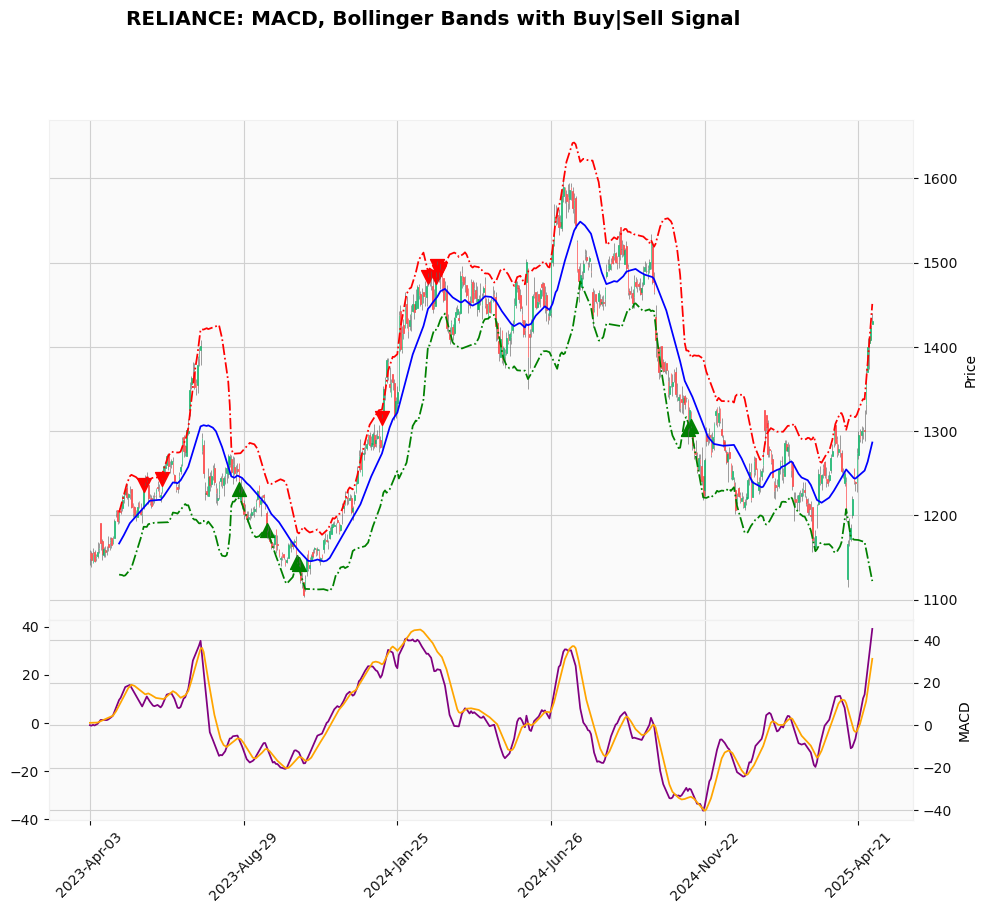

In [148]:
import matplotlib.pyplot as plt
fig = plot_stock_MACD_BB(
    stock_data_path='../data/RELIANCE.BO_2023-04-01_to_2025-05-06.csv',
    stock_name='RELIANCE'
)
plt.show()

✅ Buy signals: 0 | Sell signals: 4


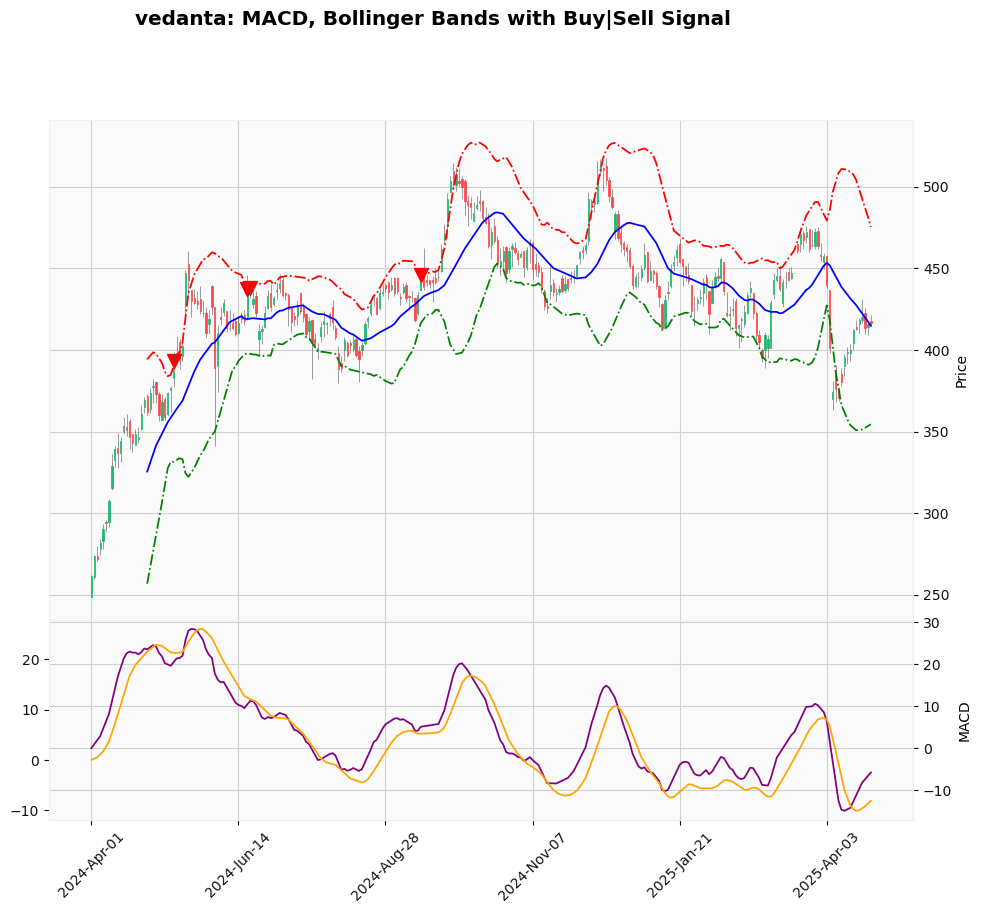

In [119]:
fig = plot_stock_MACD_BB(
    stock_data_path='../data/vedanta.csv',
    stock_name='vedanta'
)
plt.show()

✅ Buy signals: 0 | Sell signals: 27


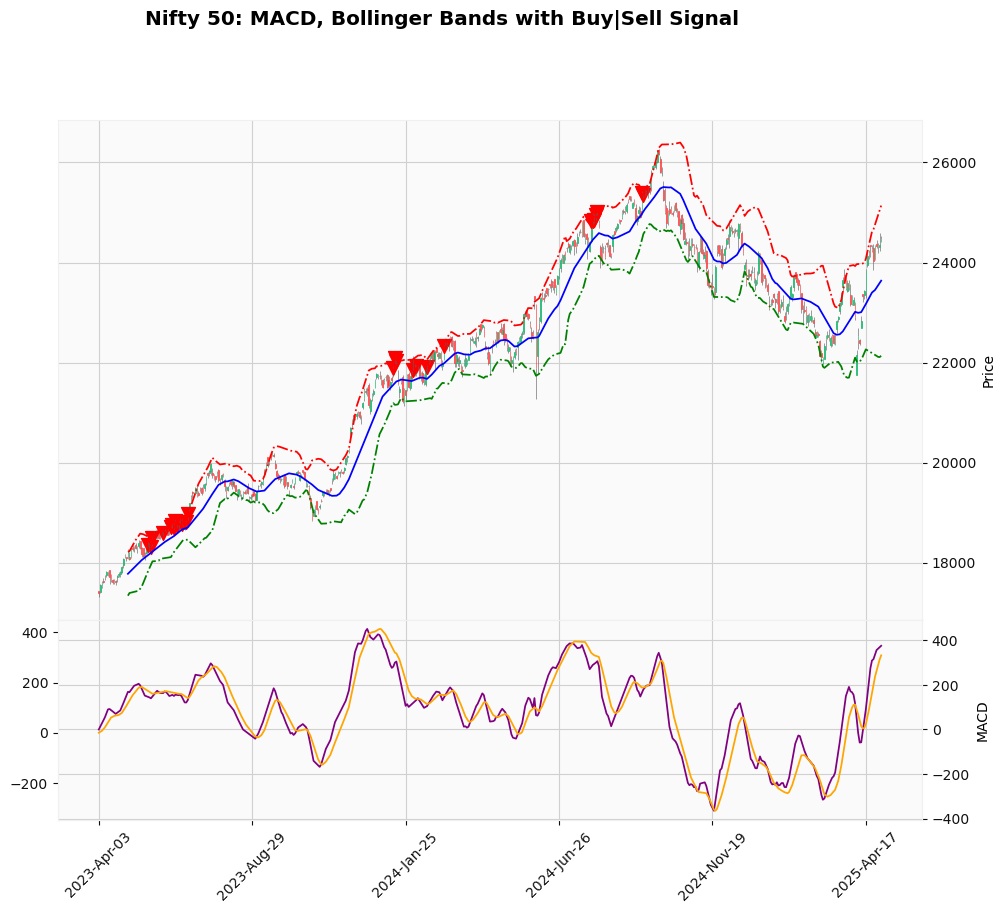

In [118]:
fig = plot_stock_MACD_BB(
    stock_data_path='../data/^NSEI_2023-04-01_to_2025-05-06.csv',
    stock_name='Nifty 50'
)
plt.show()

Buy signals: 5 | Sell signals: 17


C:\Users\RBhadani\AppData\Local\anaconda3\lib\site-packages\mplfinance\_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


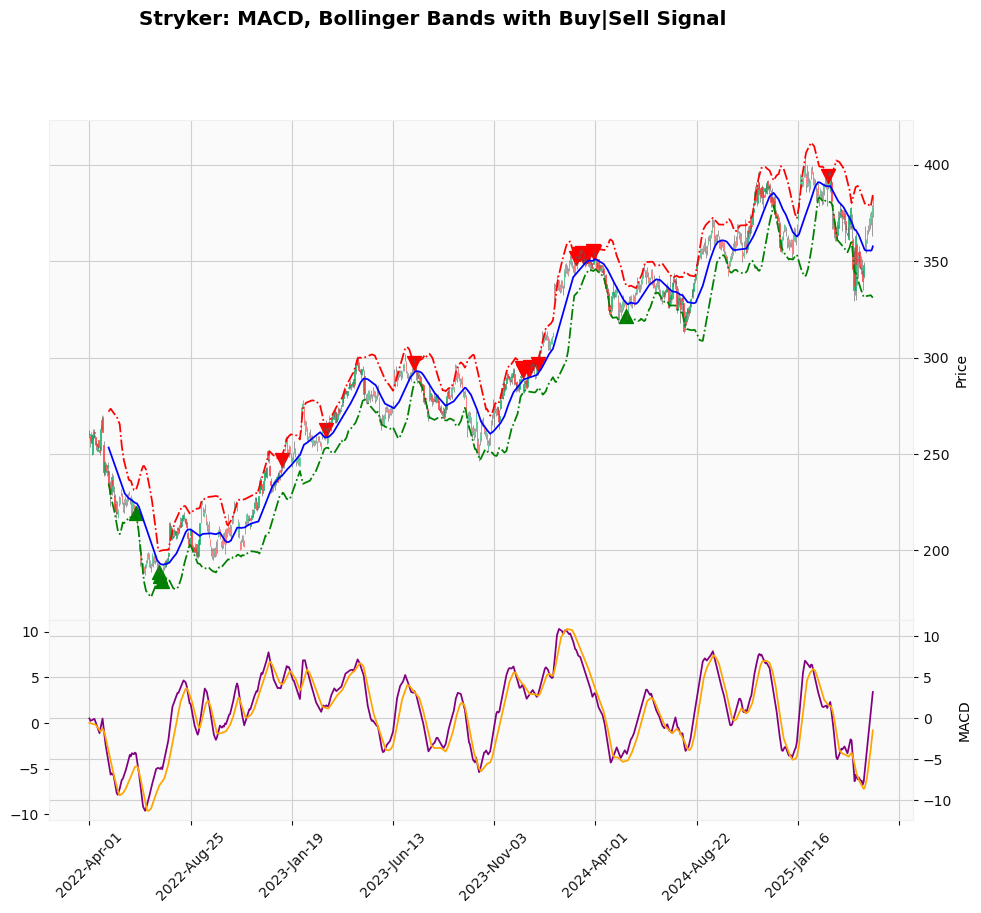

In [147]:
fig = plot_stock_MACD_BB(
    stock_data_path='../data/SYK_2022-04-01_to_2025-05-06.csv',
    stock_name='Stryker'
)
plt.show()

### Powerful Combination: MACD Divergence + Bollinger Squeeze

In [152]:
def Signal_Generator_MACD_BB_Advanced(stock_data, bandwidth_threshold=0.05):
    """
    Generate buy/sell signals based on MACD Divergence + Bollinger Squeeze logic.

    Parameters:
    - stock_data: DataFrame with MACD, Signal_Line, BB_Upper, BB_Lower, Close
    - bandwidth_threshold: Minimum compression % for squeeze detection (lower = tighter squeeze)

    Returns:
    - stock_data with added Buy_Signal_Combo and Sell_Signal_Combo columns
    """
    import pandas as pd
    try:
        # --- 1. Compute Bandwidth for Squeeze Detection ---
        stock_data['BB_Bandwidth'] = (
            (stock_data['BB_Upper'] - stock_data['BB_Lower']) / stock_data['BB_Middle']
        )

        # --- 2. MACD Histogram (for divergence-like momentum confirmation) --- Commenting: Already Added to MACD function
        # stock_data['MACD_Hist'] = stock_data['MACD'] - stock_data['Signal_Line']

        # --- 3. Signal Logic ---

        # BUY Signal:
        # - Bollinger Squeeze: BB Bandwidth < threshold
        # - MACD histogram crosses from negative to positive → momentum increasing
        stock_data['Buy_Signal_Combo'] = (
            (stock_data['BB_Bandwidth'] < bandwidth_threshold) &
            (stock_data['MACD_Hist'] > 0) &
            (stock_data['MACD_Hist'].shift(1) <= 0)
        ).astype(int)

        # SELL Signal:
        # - Bollinger Squeeze
        # - MACD histogram crosses from positive to negative → momentum weakening
        stock_data['Sell_Signal_Combo'] = (
            (stock_data['BB_Bandwidth'] < bandwidth_threshold) &
            (stock_data['MACD_Hist'] < 0) &
            (stock_data['MACD_Hist'].shift(1) >= 0)
        ).astype(int)
        
        
        print(f"📊 Squeeze-based Buy Signals: {stock_data['Buy_Signal_Combo'].sum()} | Sell Signals: {stock_data['Sell_Signal_Combo'].sum()}")
        return stock_data

    except Exception as e:
        print("❌ Error in Signal_Generator_MACD_BB_Advanced:", e)
        return stock_data

### Plot Stock With MACD Divergence + Bollinger Squeeze

In [153]:
def plot_stock_MACD_BB_Advanced(stock_data_path, stock_name, save_path=None):
    """
    Plot candlestick chart with MACD, Bollinger Bands, Bandwidth (Squeeze) & Buy/Sell signals
    based on MACD Divergence + Bollinger Squeeze strategy.

    Parameters:
    - stock_data_path: Path to CSV file with OHLCV data.
    - stock_name: Name of the stock (for title and legend).
    - save_path: Optional. If given, saves the plot to the path.

    Returns:
    - fig: Matplotlib figure object.
    """
    import pandas as pd
    import mplfinance as mpf
    import matplotlib.pyplot as plt

    # --- Load Data ---
    stock_data = DataLoder(stock_data_path)

    # --- MACD + Bollinger Calculation ---
    stock_data = MACD_Calculator(stock_data)
    stock_data = Bollinger_Band_Calculator(stock_data)

    # --- Signal Generation (Squeeze + MACD Histogram)
    stock_data = Signal_Generator_MACD_BB_Advanced(stock_data)
    
    #--- Save stock_data to CSV for backtesting later ---
    stock_data.to_csv(f'../data/{stock_name}_buy_sell_signal_MACD_BB_Advanced.csv', index=True)

    # --- Create Buy/Sell plots with full index ---
    buy_plot = pd.Series(index=stock_data.index, dtype=float)
    sell_plot = pd.Series(index=stock_data.index, dtype=float)

    buy_plot[stock_data['Buy_Signal_Combo'] == 1] = stock_data['Close'][stock_data['Buy_Signal_Combo'] == 1]
    sell_plot[stock_data['Sell_Signal_Combo'] == 1] = stock_data['Close'][stock_data['Sell_Signal_Combo'] == 1]

    # --- Prepare additional plots ---
    apds = [
        mpf.make_addplot(stock_data['BB_Upper'], linestyle='dashdot', color='red'),
        mpf.make_addplot(stock_data['BB_Lower'], linestyle='dashdot', color='green'),
        mpf.make_addplot(stock_data['BB_Middle'], color='blue'),
        mpf.make_addplot(stock_data['MACD'], panel=1, color='purple', ylabel='MACD'),
        mpf.make_addplot(stock_data['Signal_Line'], panel=1, color='orange'),
        mpf.make_addplot(stock_data['MACD_Hist'], panel=1, type='bar', color='grey', width=0.7),
        mpf.make_addplot(stock_data['BB_Bandwidth'], panel=2, color='black', ylabel='Bandwidth')
    ]

    # --- Add Buy/Sell signal markers ---
    if not buy_plot.dropna().empty:
        apds.append(mpf.make_addplot(buy_plot, type='scatter', marker='^', color='green', markersize=100))
    if not sell_plot.dropna().empty:
        apds.append(mpf.make_addplot(sell_plot, type='scatter', marker='v', color='red', markersize=100))

    # --- Plotting ---
    fig, _ = mpf.plot(
        stock_data[['Open', 'High', 'Low', 'Close', 'Volume']],
        type='candle',
        style='yahoo',
        title=f'{stock_name}: MACD Divergence + Bollinger Squeeze Signals',
        addplot=apds,
        returnfig=True,
        panel_ratios=(4, 3, 1),
        volume=False,
        figsize=(14, 10)
    )

    # --- Save if path provided ---
    if save_path:
        fig.savefig(save_path)
        print(f"Plot saved to {save_path}")

    return fig

📊 Squeeze-based Buy Signals: 1 | Sell Signals: 4


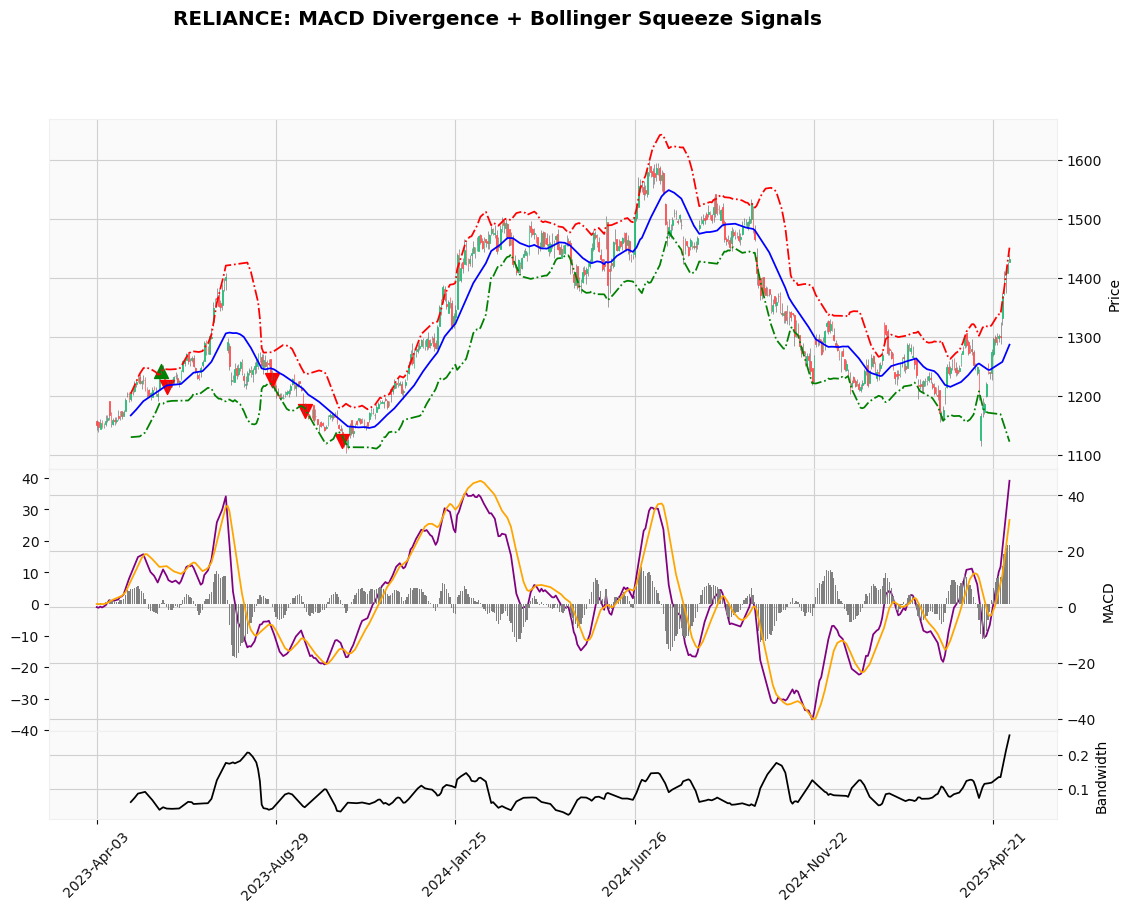

In [127]:
fig = plot_stock_MACD_BB_Advanced(
    stock_data_path='../data/RELIANCE.BO_2023-04-01_to_2025-05-06.csv',
    stock_name='RELIANCE'
)
plt.show()

📊 Squeeze-based Buy Signals: 2 | Sell Signals: 1


C:\Users\RBhadani\AppData\Local\anaconda3\lib\site-packages\mplfinance\_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


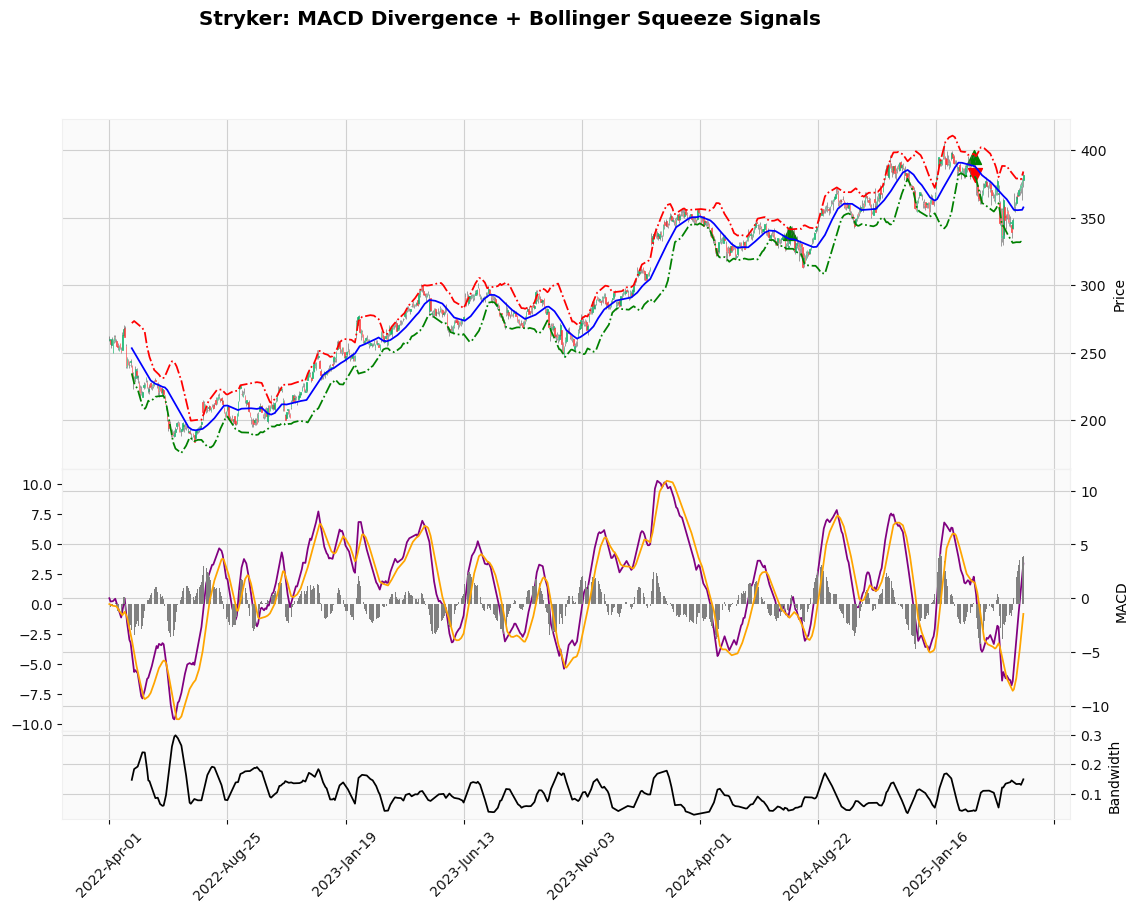

In [128]:
fig = plot_stock_MACD_BB_Advanced(
    stock_data_path='../data/SYK_2022-04-01_to_2025-05-06.csv',
    stock_name='Stryker'
)
plt.show()

📊 Squeeze-based Buy Signals: 14 | Sell Signals: 11


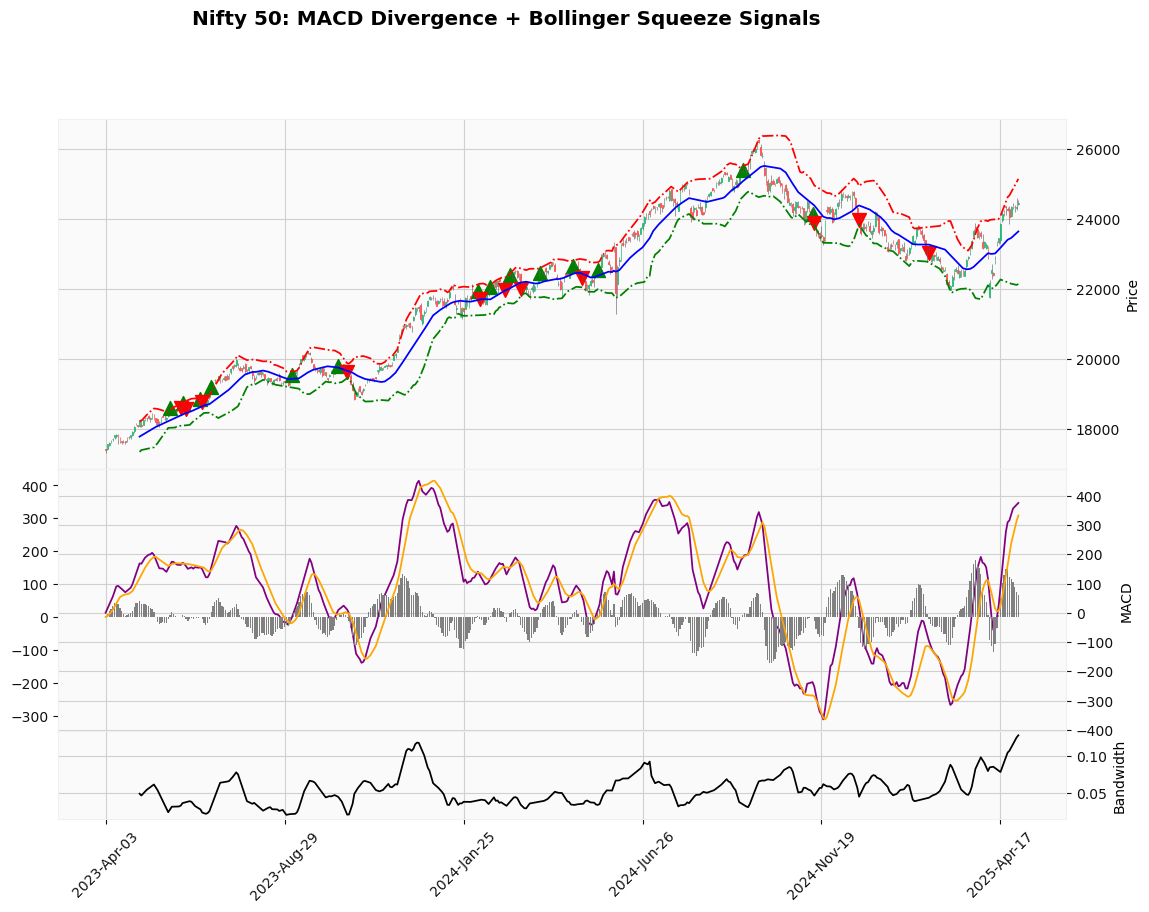

In [154]:
fig = plot_stock_MACD_BB_Advanced(
    stock_data_path='../data/^NSEI_2023-04-01_to_2025-05-06.csv',
    stock_name='Nifty 50'
)
plt.show()

📊 Squeeze-based Buy Signals: 0 | Sell Signals: 0


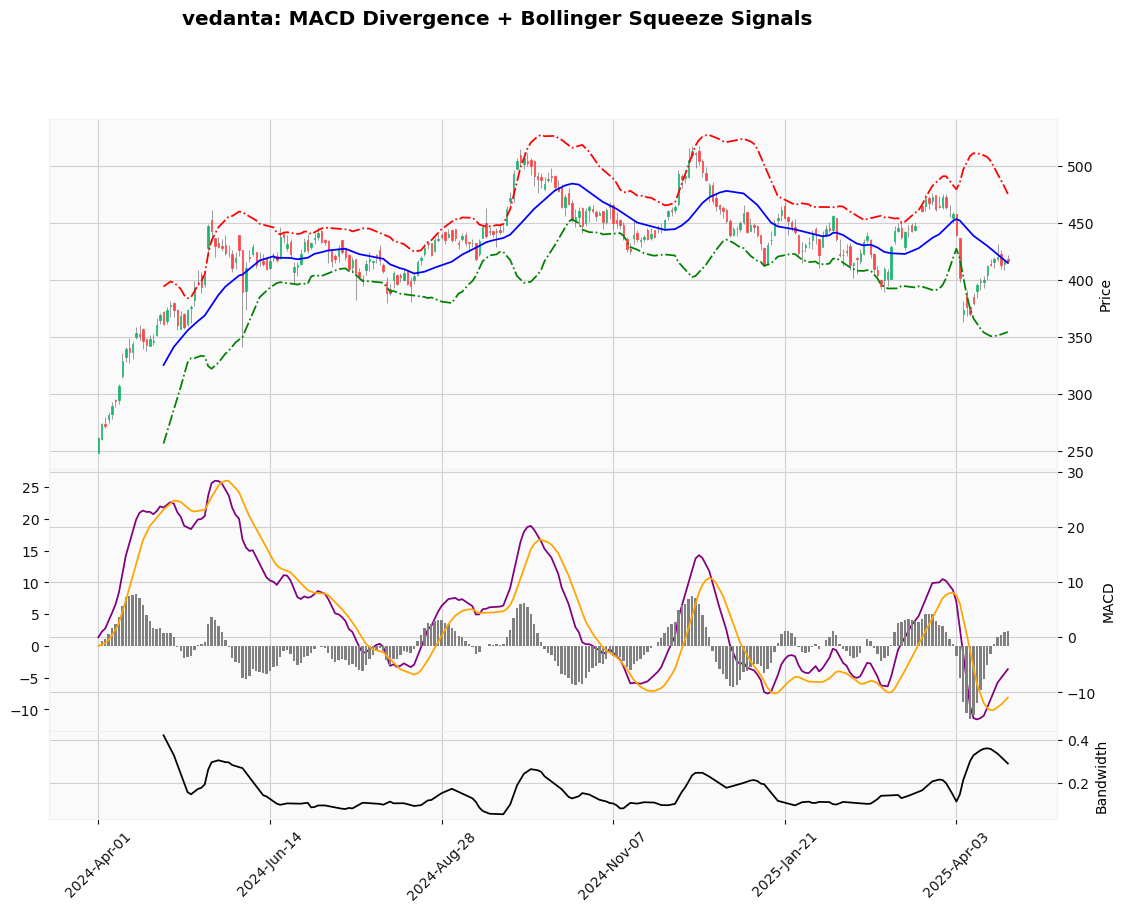

In [130]:
fig = plot_stock_MACD_BB_Advanced(
    stock_data_path='../data/vedanta.csv',
    stock_name='vedanta'
)
plt.show()

## Multi-Indicator Strategy Design + Signal Filtering

### Signal Generator for multiIndicator Strategy

- **Buy Signal (Multi-Stacked):**
    - RSI< 35 (OverSold)
    - MACD Histogram > 0 and Crossing from Below(Bullish Momentum)
    - Price near or below Lower Bollinger Band
    - SMA_20 > SMA_50 (Uptrand Confirmation)
- **Sell Signal:**
    - RSI > 65 (OverBought)
    - MACD Histogram < 0 
    - Price near or above Upper Bollinger Band
    - SMA_20 < SMA_50
    

In [180]:
def Signal_Generator_MultiIndicator(stock_data):
    import pandas as pd
    try:
        stock_data['Buy_Multi'] = (
            (stock_data['RSI'] < 40) &
            (stock_data['MACD_Hist'] > 0) &
            (stock_data['MACD_Hist'].shift(1) <= 0) &
            (stock_data['Close'] <= stock_data['BB_Lower'] * 1.01) #&
            #(stock_data['SMA_20'] > stock_data['SMA_50'])
        ).astype(int)

        stock_data['Sell_Multi'] = (
            (stock_data['RSI'] > 60) &
            (stock_data['MACD_Hist'] < 0) &
            (stock_data['MACD_Hist'].shift(1) >= 0) &
            (stock_data['Close'] >= stock_data['BB_Upper'] * 0.99) #&
            #(stock_data['SMA_20'] < stock_data['SMA_50'])
        ).astype(int)

        print(f"Buy: {stock_data['Buy_Multi'].sum()} | Sell: {stock_data['Sell_Multi'].sum()}")
        return stock_data

    except Exception as e:
        print("Error in Signal_Generator_MultiIndicator:", e)
        return stock_data
        

### Plot Stock with Multi_Indicators

In [169]:
def plot_stock_MultiIndicator(stock_data_path, stock_name, save_path=None):
    """
    Plot candlestick chart with Bollinger Bands, MACD, RSI, SMA lines, and Multi-Indicator strategy buy/sell signals.

    Parameters:
    - stock_data_path: CSV file path for stock data
    - stock_name: Name of the stock (for title)
    - save_path: Optional file path to save the plot

    Returns:
    - fig: Matplotlib figure object
    """
    import pandas as pd
    import mplfinance as mpf
    import matplotlib.pyplot as plt

    # Load and process data
    stock_data = DataLoder(stock_data_path)
    stock_data = MACD_Calculator(stock_data)
    stock_data = Bollinger_Band_Calculator(stock_data)
    stock_data = SMA_Calculator(stock_data, days=20) # calculates SMA_20
    stock_data = SMA_Calculator(stock_data, days=50)  # calculates SMA_50
    stock_data = RSI_Calculator(stock_data)
    stock_data = Signal_Generator_MultiIndicator(stock_data)
    
    #--- Save stock_data to CSV for backtesting later ---
    stock_data.to_csv(f'../data/{stock_name}_buy_sell_signal_Multi.csv', index=True)
    strategy_debug_report(stock_data)

    # Create buy/sell marker series
    buy_plot = pd.Series(index=stock_data.index, dtype=float)
    sell_plot = pd.Series(index=stock_data.index, dtype=float)

    buy_plot[stock_data['Buy_Multi'] == 1] = stock_data['Close'][stock_data['Buy_Multi'] == 1]
    sell_plot[stock_data['Sell_Multi'] == 1] = stock_data['Close'][stock_data['Sell_Multi'] == 1]

    # Build addplots
    apds = [
        mpf.make_addplot(stock_data['BB_Upper'], linestyle='dashdot', color='red'),
        mpf.make_addplot(stock_data['BB_Lower'], linestyle='dashdot', color='green'),
        mpf.make_addplot(stock_data['BB_Middle'], color='blue'),
        mpf.make_addplot(stock_data['SMA_20'], color='orange'),
        mpf.make_addplot(stock_data['SMA_50'], color='purple'),
        mpf.make_addplot(stock_data['MACD'], panel=1, color='purple', ylabel='MACD'),
        mpf.make_addplot(stock_data['Signal_Line'], panel=1, color='orange'),
        mpf.make_addplot(stock_data['MACD'] - stock_data['Signal_Line'], panel=1, type='bar', color='gray'),
        mpf.make_addplot(stock_data['RSI'], panel=2, color='navy', ylabel='RSI')
    ]

    # Add buy/sell markers
    if not buy_plot.dropna().empty:
        apds.append(mpf.make_addplot(buy_plot, type='scatter', color='green', marker='^', markersize=100))
    if not sell_plot.dropna().empty:
        apds.append(mpf.make_addplot(sell_plot, type='scatter', color='red', marker='v', markersize=100))

    # Plot config
    fig, _ = mpf.plot(
        stock_data[['Open', 'High', 'Low', 'Close', 'Volume']],
        type='candle',
        style='yahoo',
        title=f'{stock_name}: Multi-Indicator Strategy Signals',
        addplot=apds,
        returnfig=True,
        panel_ratios=(3, 2, 1),
        volume=False,
        figsize=(14, 10)
    )

    # Save optional
    if save_path:
        fig.savefig(save_path)
        print(f"Plot saved to {save_path}")

    return fig

In [167]:
def strategy_debug_report(stock_data):
    """
    Print a diagnostic report of the Buy/Sell strategy:
    - Individual condition match counts
    - Combined score distribution
    - Buy/Sell signal frequency
    """
    print("📊 Strategy Debug Report".center(50, "-"))

    # --- Individual Buy Conditions ---
    rsi_cond = (stock_data['RSI'] < 40)
    macd_cross = (stock_data['MACD_Hist'] > 0) & (stock_data['MACD_Hist'].shift(1) <= 0)
    bb_cond = (stock_data['Close'] <= stock_data['BB_Lower'] * 1.03)
    trend_cond = (stock_data['SMA_20'] > stock_data['SMA_50'])

    print(f"🔹 RSI < 40: {rsi_cond.sum()} matches")
    print(f"🔹 MACD Histogram Cross > 0: {macd_cross.sum()} matches")
    print(f"🔹 Close near Lower Bollinger Band: {bb_cond.sum()} matches")
    print(f"🔹 SMA_20 > SMA_50 (uptrend): {trend_cond.sum()} matches")

    # --- Optional: Store scores ---
    score = rsi_cond.astype(int) + macd_cross.astype(int) + bb_cond.astype(int) + trend_cond.astype(int)
    stock_data['Buy_Score_Debug'] = score

    print("\n📈 Buy Signal Score Distribution:")
    print(score.value_counts().sort_index())

    # --- Existing Final Signals (if already added) ---
    if 'Buy_Multi' in stock_data.columns:
        print(f"\n✅ Final Buy Signals Triggered: {stock_data['Buy_Multi'].sum()}")

    if 'Sell_Multi' in stock_data.columns:
        print(f"❌ Final Sell Signals Triggered: {stock_data['Sell_Multi'].sum()}")

    print("-" * 50)

Buy: 0 | Sell: 0
-------------📊 Strategy Debug Report--------------
🔹 RSI < 40: 97 matches
🔹 MACD Histogram Cross > 0: 22 matches
🔹 Close near Lower Bollinger Band: 253 matches
🔹 SMA_20 > SMA_50 (uptrend): 329 matches

📈 Buy Signal Score Distribution:
0     87
1    192
2    187
3     45
dtype: int64

✅ Final Buy Signals Triggered: 0
❌ Final Sell Signals Triggered: 0
--------------------------------------------------


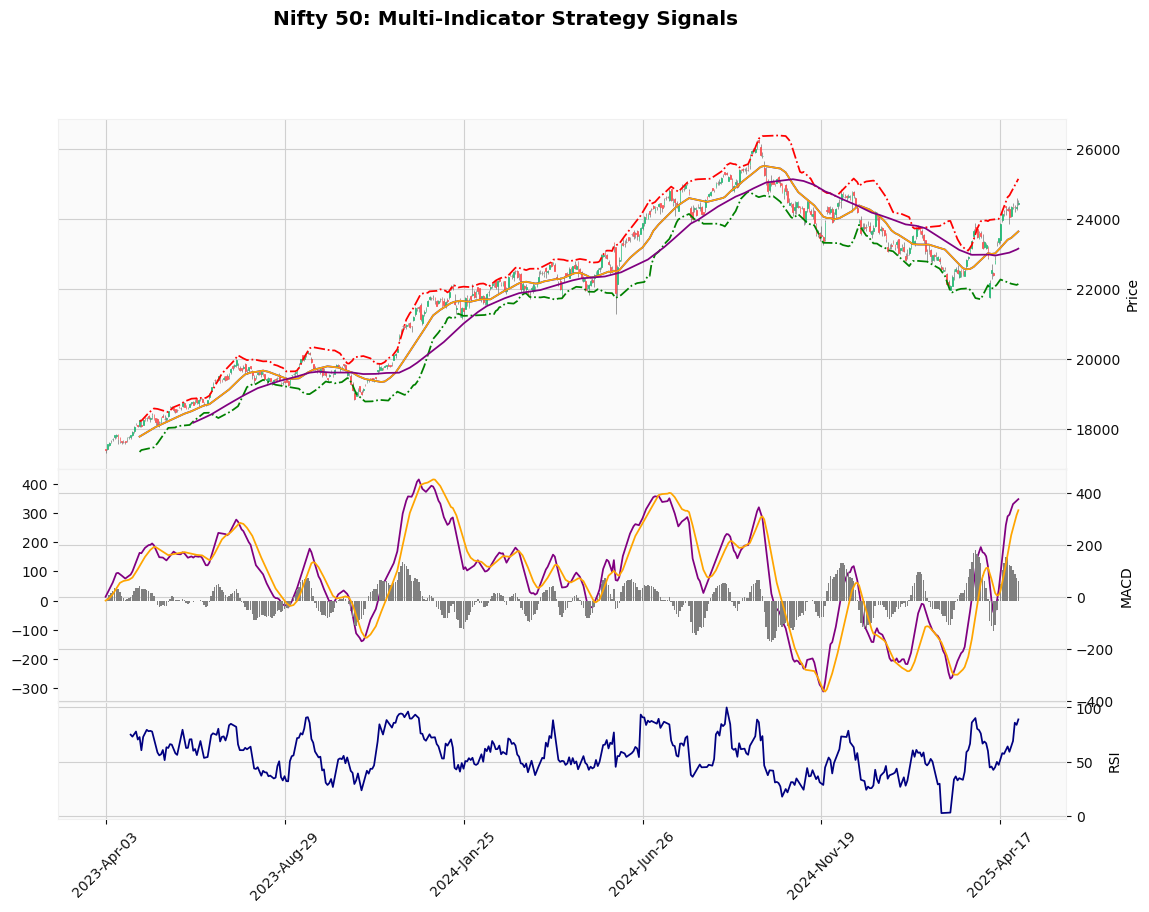

In [144]:
fig = plot_stock_MultiIndicator(
    stock_data_path='../data/^NSEI_2023-04-01_to_2025-05-06.csv',
    stock_name='Nifty 50'
)
plt.show()

Buy: 0 | Sell: 0
-------------📊 Strategy Debug Report--------------
🔹 RSI < 40: 134 matches
🔹 MACD Histogram Cross > 0: 26 matches
🔹 Close near Lower Bollinger Band: 171 matches
🔹 SMA_20 > SMA_50 (uptrend): 207 matches

📈 Buy Signal Score Distribution:
0    147
1    212
2    127
3     24
dtype: int64

✅ Final Buy Signals Triggered: 0
❌ Final Sell Signals Triggered: 0
--------------------------------------------------


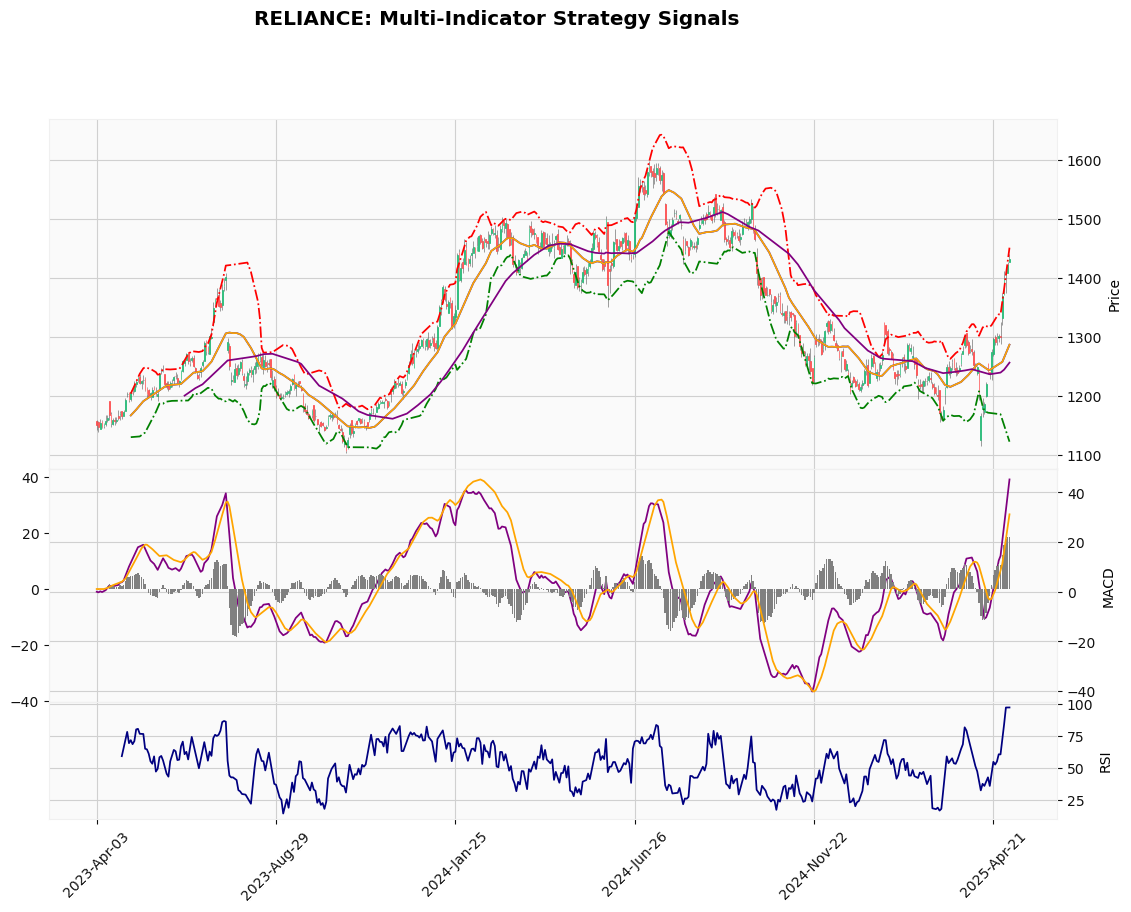

In [165]:
fig = plot_stock_MultiIndicator(
    stock_data_path='../data/RELIANCE.BO_2023-04-01_to_2025-05-06.csv',
    stock_name='RELIANCE'
)
plt.show()

In [175]:
# Analyze 6 years of Stryker Data
stock_data_path='../data/SYK_2019-04-01_to_2025-05-06.csv'
stock_name='Stryker'

Buy signals: 7 | Sell signals: 31


C:\Users\RBhadani\AppData\Local\anaconda3\lib\site-packages\mplfinance\_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


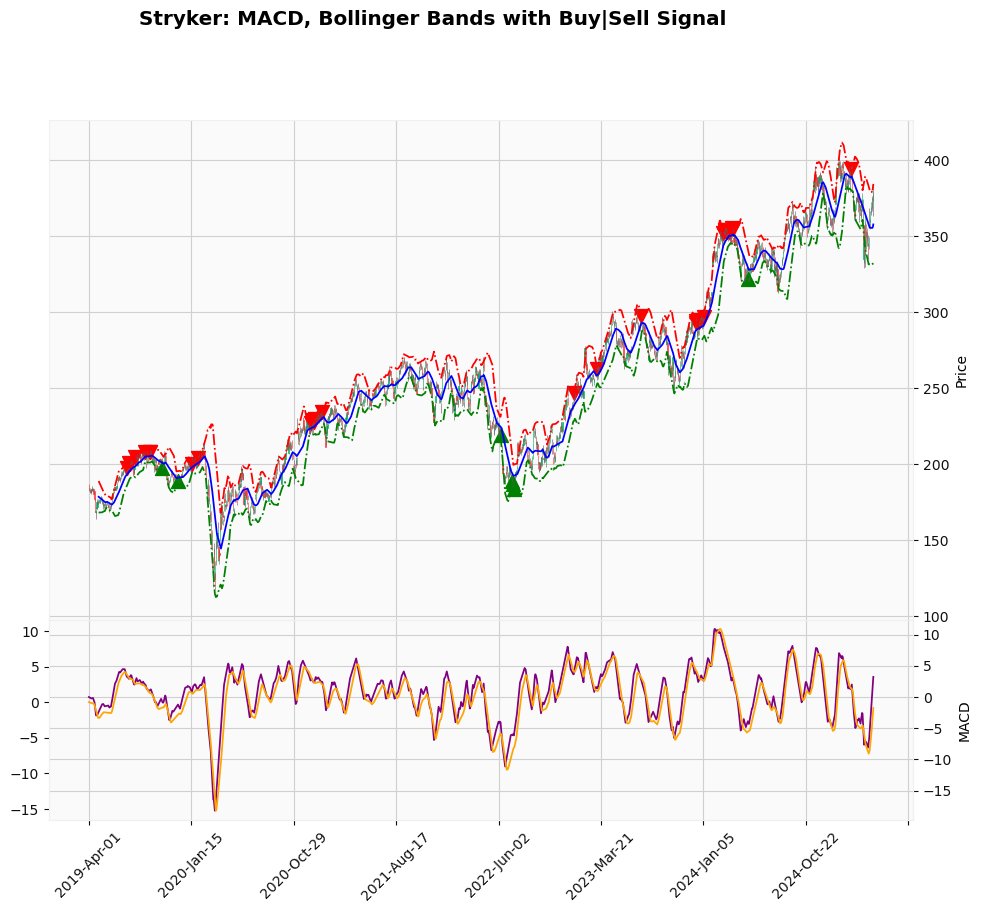

In [176]:
fig = plot_stock_MACD_BB(
    stock_data_path=stock_data_path,
    stock_name=stock_name
)
plt.show()

📊 Squeeze-based Buy Signals: 10 | Sell Signals: 4


C:\Users\RBhadani\AppData\Local\anaconda3\lib\site-packages\mplfinance\_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


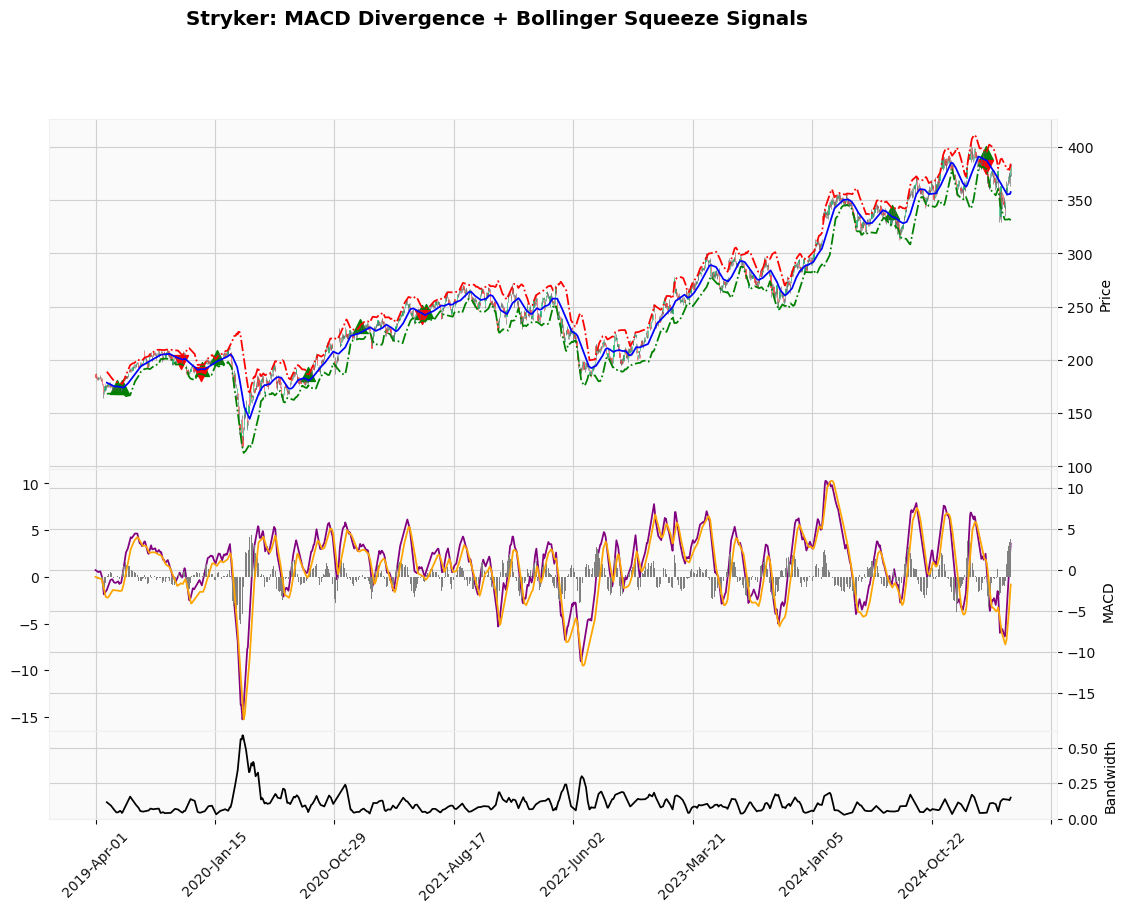

In [177]:
fig = plot_stock_MACD_BB_Advanced(
    stock_data_path=stock_data_path,
    stock_name=stock_name
)
plt.show()

Buy: 0 | Sell: 0
-------------📊 Strategy Debug Report--------------
🔹 RSI < 40: 345 matches
🔹 MACD Histogram Cross > 0: 61 matches
🔹 Close near Lower Bollinger Band: 457 matches
🔹 SMA_20 > SMA_50 (uptrend): 956 matches

📈 Buy Signal Score Distribution:
0    312
1    767
2    310
3    144
dtype: int64

✅ Final Buy Signals Triggered: 0
❌ Final Sell Signals Triggered: 0
--------------------------------------------------


C:\Users\RBhadani\AppData\Local\anaconda3\lib\site-packages\mplfinance\_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


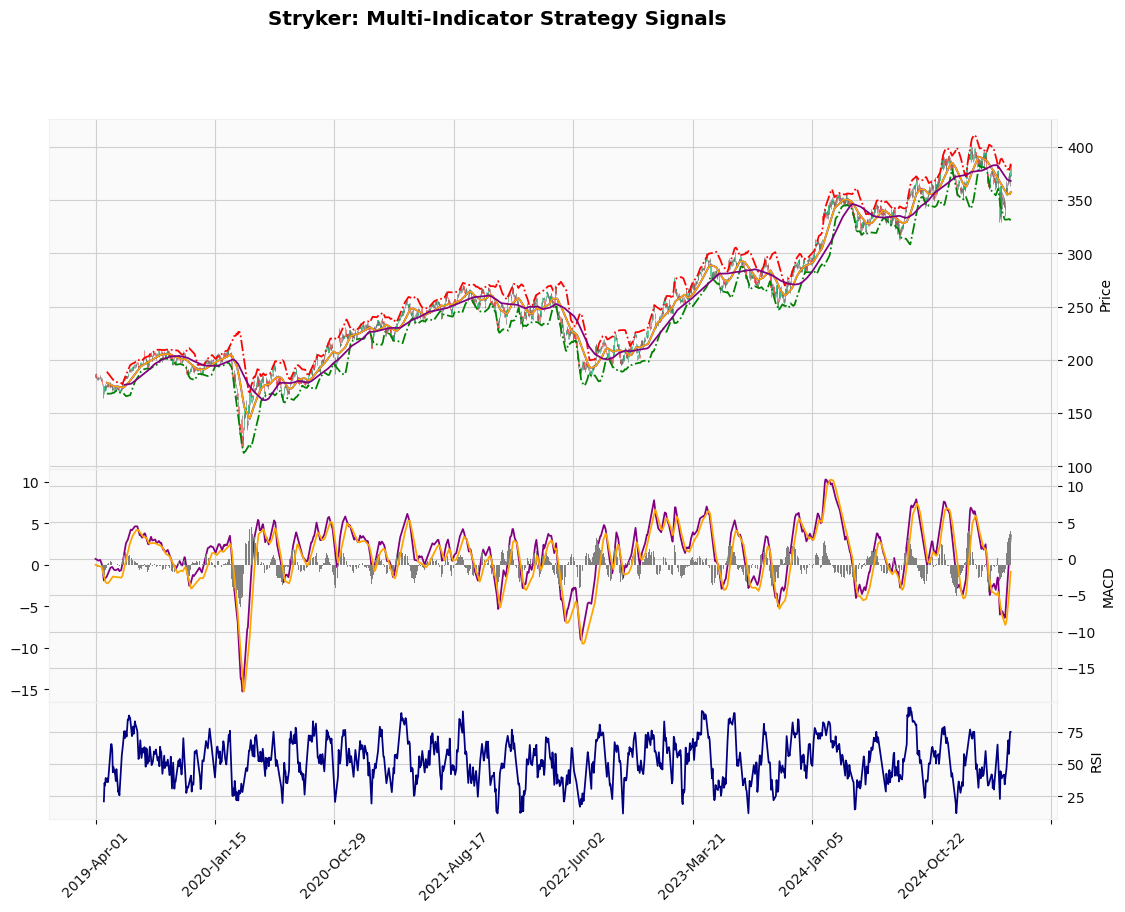

In [181]:
fig = plot_stock_MultiIndicator(
    stock_data_path=stock_data_path,
    stock_name=stock_name
)
plt.show()